In [1]:
# hide
# default_exp datasets

from nbdev.showdoc import *

# Item Repetitions Analyses
> Siegel, L. L., & Kahana, M. J. (2014). A retrieved context account of spacing and repetition effects in free recall. Journal of Experimental Psychology: Learning, Memory, and Cognition, 40(3), 755.

Next we'll consider whether the models fit as similarly to datasets with item repetitions involved.

## The Dataset
Across 4 sessions, 35 subjects performed delayed free recall of 48 lists. Subjects were University of Pennsylvania undergraduates, graduates and staff, age 18-32. List items were drawn from a pool of 1638 words taken from the University of South Florida free association norms (Nelson, McEvoy, & Schreiber, 2004; Steyvers, Shiffrin, & Nelson, 2004, available at http://memory.psych.upenn.edu/files/wordpools/PEERS_wordpool.zip). Within each session, words were drawn without replacement. Words could repeat across sessions so long as they did not repeat in two successive sessions. Words were also selected to ensure that no strong semantic associates co-occurred in a given list (i.e., the semantic relatedness between any two words on a given list, as determined using WAS (Steyvers et al., 2004), did not exceed a threshold value of 0.55).

Subjects encountered four different types of lists: 
1. Control lists that contained all once-presented items;  
2. pure massed lists containing all twice-presented items; 
3. pure spaced lists consisting of items presented twice at lags 1-8, where lag is defined as the number of intervening items between a repeated item's presentations; 
4. mixed lists consisting of once presented, massed and spaced items. Within each session, subjects encountered three lists of each of these four types. 

In each list there were 40 presentation positions, such that in the control lists each position was occupied by a unique list item, and in the pure massed and pure spaced lists, 20 unique words were presented twice to occupy the 40 positions. In the mixed lists 28 once-presented and six twice-presented words occupied the 40 positions. In the pure spaced lists, spacings of repeated items were chosen so that each of the lags 1-8 occurred with equal probability. In the mixed lists, massed repetitions (lag=0) and spaced repetitions (lags 1-8) were chosen such that each of the 9 lags of 0-8 were used exactly twice within each session. The order of presentation for the different list types was randomized within each session. For the first session, the first four lists were chosen so that each list type was presented exactly once. An experimenter sat in with the subject for these first four lists, though no subject had difficulty understanding the task.

The data for this experiment is stored in `data/repFR.mat`. We define a unique `prepare_repetition_data` function to build structures from the dataset that works with our existing data analysis and fitting functions.

Like in `prepare_murd_data`, we need list lengths, a data frame for visualizations with psifir, and a trials array encoding recall events as sequences of presentation positions. But we'll also need an additional array tracking presentation order, too.

In [1]:
# export

import scipy.io as sio
import numpy as np
import pandas as pd
from psifr import fr

def prepare_repdata(path):
    """
    Prepares data formatted like `data/repFR.mat` for fitting.
    """
    
    # load all the data
    matfile = sio.loadmat(path, squeeze_me=True)['data'].item()
    subjects = matfile[0]
    pres_itemnos = matfile[4]
    recalls = matfile[6]
    list_types = matfile[7]
    list_length = matfile[12]
    
    # convert pres_itemnos into rows of unique indices for easier model encoding
    presentations = []
    for i in range(len(pres_itemnos)):
        seen = []
        presentations.append([])
        for p in pres_itemnos[i]:
            if p not in seen:
                seen.append(p)
            presentations[-1].append(seen.index(p))
    presentations = np.array(presentations)

    # discard intrusions from recalls
    trials = []
    for i in range(len(recalls)):
        trials.append([])
        
        trial = list(recalls[i])
        for t in trial:
            if (t > 0) and (t not in trials[-1]):
                trials[-1].append(t)
        
        while len(trials[-1]) < list_length:
            trials[-1].append(0)
            
    trials = np.array(trials)
    
    # encode dataset into psifr format
    data = []
    for trial_index, trial in enumerate(trials):
        presentation = presentations[trial_index]
        
        # every time the subject changes, reset list_index
        if not data or data[-1][0] != subjects[trial_index]:
            list_index = 0
        list_index += 1
        
        # add study events
        for presentation_index, presentation_event in enumerate(presentation):
            data += [[subjects[trial_index], 
                      list_index, 'study', presentation_index+1, presentation_event,  list_types[trial_index]
                     ]]
            
        # add recall events
        for recall_index, recall_event in enumerate(trial):
            if recall_event != 0:
                data += [[subjects[trial_index], list_index, 
                          'recall', recall_index+1, presentation[recall_event-1], list_types[trial_index]
                         ]]
                
    data = pd.DataFrame(data, columns=[
        'subject', 'list', 'trial_type', 'position', 'item', 'condition'])
    merged = fr.merge_free_recall(data, list_keys=['condition'])
    
    return trials, merged, list_length, presentations, list_types, data, subjects

In [2]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_repdata(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


## Benchmark Visualizations

Let's also visualize the variation between subjects in dataset with respect to our main organizational metrics.

1


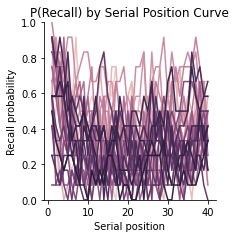

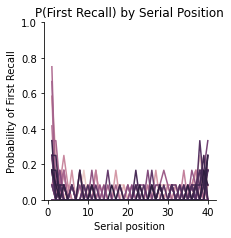

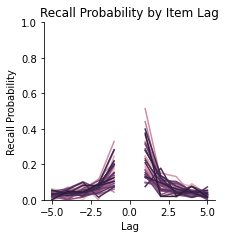

2


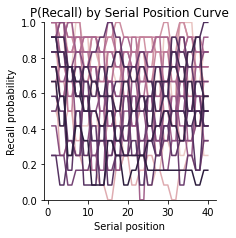

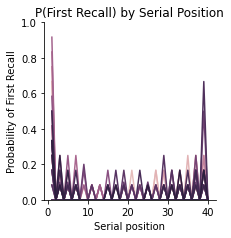

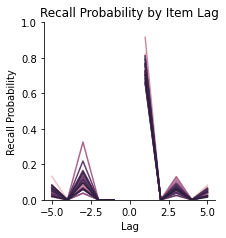

3


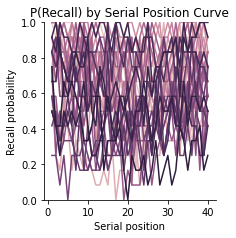

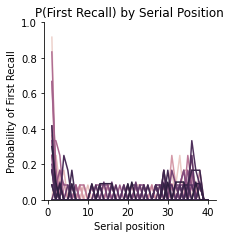

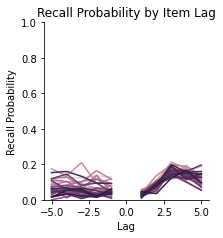

4


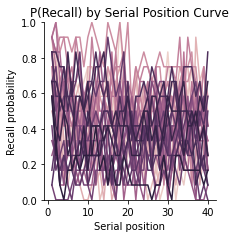

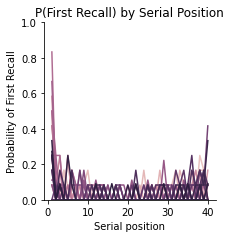

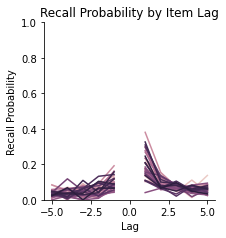

aggregate


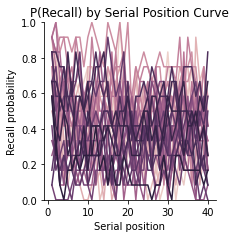

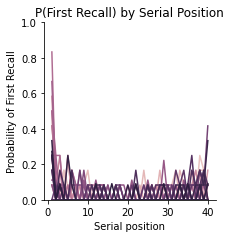

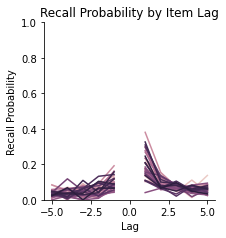

In [3]:
from instance_cmr.datasets import visualize_individuals
import matplotlib.pyplot as plt

for condition in [1, 2, 3, 4]:
    print(condition)
    visualize_individuals(events[events.condition == condition], 'subject > -1')
    plt.show()

print('aggregate')
visualize_individuals(events[events.condition == condition], 'subject > -1')


Since this looks janky, we'll also implement an overdue `visualize_aggregate` function to reassure us about the overall distribution of values on these measures.

In [3]:
#export

import pandas as pd
import seaborn as sns
from psifr import fr
import matplotlib.pyplot as plt

def visualize_aggregate(data, data_query):
    
    # generate data-based spc, pnr, lag_crp
    data_spc = fr.spc(data).query(data_query).reset_index()
    data_pfr = fr.pnr(data).query('output <= 1').query(data_query).reset_index()
    data_lag_crp = fr.lag_crp(data).query(data_query).reset_index()

    # spc
    g = sns.FacetGrid(dropna=False, data=data_spc)
    g.map_dataframe(sns.lineplot, x='input', y='recall',)
    g.set_xlabels('Serial position')
    g.set_ylabels('Recall probability')
    #plt.title('Recall Probability by Serial Position')
    g.set(ylim=(0, 1))
    plt.savefig('spc.pdf', bbox_inches='tight')

    # pfr
    h = sns.FacetGrid(dropna=False, data=data_pfr)
    h.map_dataframe(sns.lineplot, x='input', y='prob')
    h.set_xlabels('Serial position')
    h.set_ylabels('Probability of First Recall')
    #plt.title('P(First Recall) by Serial Position')
    h.set(ylim=(0, 1))
    plt.savefig('pfr.pdf', bbox_inches='tight')

    # lag crp
    max_lag = 5
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    i = sns.FacetGrid(dropna=False, data=data_lag_crp)
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_neg),
                                         x='lag', y='prob', **kws))
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_pos),
                                         x='lag', y='prob', **kws))
    i.set_xlabels('Item Lag')
    i.set_ylabels('Conditional Response Probability')
    #plt.title('Recall Probability by Item Lag')
    i.set(ylim=(0, 1))
    plt.savefig('crp.pdf', bbox_inches='tight')

1


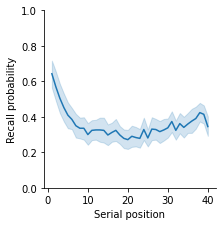

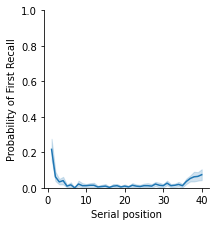

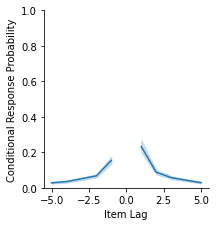

2


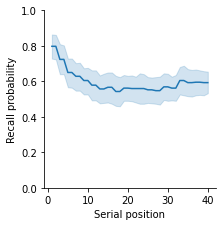

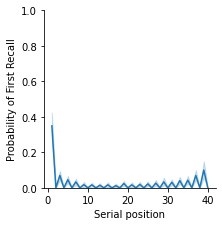

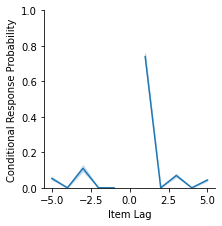

3


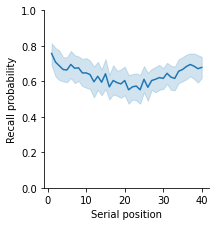

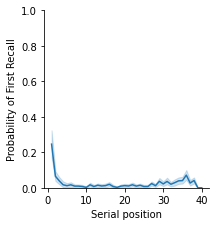

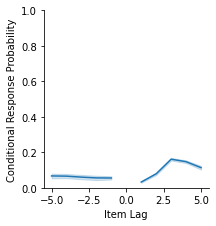

4


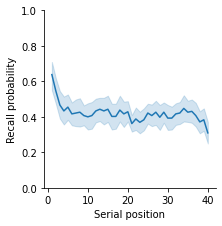

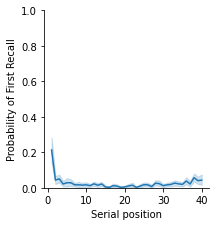

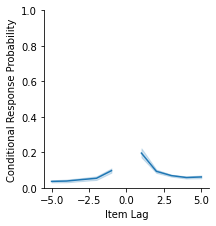

all


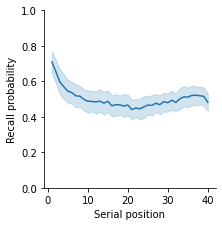

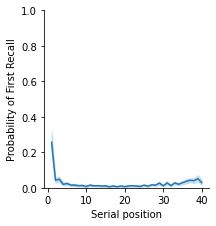

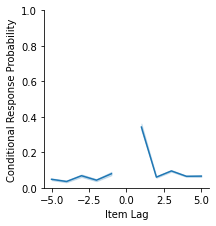

In [7]:
for condition in [1, 2, 3, 4]:
    print(condition)
    visualize_aggregate(events[events.condition == condition], 'subject > -1')
    plt.show()
    
print('all')
visualize_aggregate(events, 'subject > -1')

## Spacing Analyses
What do I do? Use my `trials` and `presentations` arrays. Start two empty 4-unit vectors for tracking the numerators and denominators of the four conditions I'm comparing. Consider my `presentations` array first. For every unique item, figure out the right bin in my spacing analysis (number of intervening items = 0, 1-2, 3-5, 6-8) and increment my denominator array accordingly. Also check in my `trials` array if the unique item was recalled, and increment my numerator array accordingly.

Plot numerator/denominator.

In [4]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_repdata(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


In [5]:
# export

def recall_probability_by_lag(presentations, trials):

    presented, retrieved = np.zeros(5), np.zeros(5)

    for trial_index, sequence in enumerate(presentations):

        # retrieve trial information
        trial = trials[trial_index]

        # extract list of recalled items
        recalled = sequence[trial-1][trial != 0]

        for item in np.unique(sequence):
            locations = np.where(sequence == item)[0]

            # presented just once
            if len(locations) == 1:
                index = 0
            else: 

                # no intervening items (massed)
                lag = locations[1] - locations[0] - 1
                if lag == 0:
                    index = 1

                # 1-2 intervening items
                elif lag <= 2:
                    index = 2

                # 3-5
                elif lag <= 5:
                    index = 3

                # 6-8
                else:
                    index = 4

            presented[index] += 1
            retrieved[index] += item in recalled
        
    return retrieved, presented, retrieved/presented

In [6]:
# export

from tqdm import tqdm

def sim_recall_probability_by_lag(model_class, parameters, presentations, experiment_count=1000, savefig=False):
    """
    Apply organizational analyses to visually compare the behavior of the model 
    with these parameters against specified dataset.
    """
    
    total_presented, total_retrieved = np.zeros(5), np.zeros(5)
    
    # generate simulation data from model
    for experiment in tqdm(range(experiment_count)):
        sim = np.zeros(np.shape(presentations), dtype=int)
        for trial_index, presentation in enumerate(presentations):
            
            item_count = np.max(presentation)+1
            model = model_class(**{'item_count': item_count, **parameters})

            # simulate study events
            try:
                model.experience(np.eye(model.item_count, model.item_count + 1, 1)[presentation])
            except ValueError:
                model.experience(np.eye(model.item_count, model.item_count)[presentation])
            
            # simulate and add recall events to trials array
            recalled = model.free_recall() + 1
            sim[trial_index, :len(recalled)] = recalled
            
        retrieved, presented = recall_probability_by_lag(presentations, sim)[:2]
        total_presented += presented
        total_retrieved += retrieved
        
    return total_retrieved, total_presented, total_retrieved/total_presented

### Raw Data

[0.37278912 0.43928571 0.47678571 0.55714286 0.57857143]
[0.0664966  0.0375     0.08035714 0.02142857]


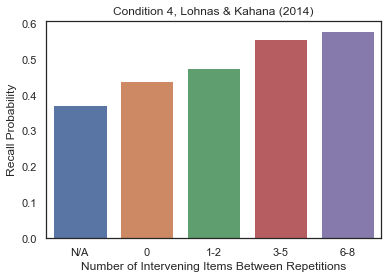

In [7]:
import seaborn as sns
sns.set_theme(style="white")

result = recall_probability_by_lag(presentations[list_types==4], trials[list_types==4])[-1]
print(result)
print(result[1:] - result[:-1])
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=result)
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('Condition 4, Lohnas & Kahana (2014)')
plt.show()

### CMR

In [8]:
from instance_cmr.models import CMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

parameters = {
    'presentation_count': list_length, 
}

#### Fitted Across Murd62 Dataset

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]

[0.14510544 0.27814286 0.31958929 0.29461905 0.29872619]
[ 0.13303741  0.04144643 -0.02497024  0.00410714]


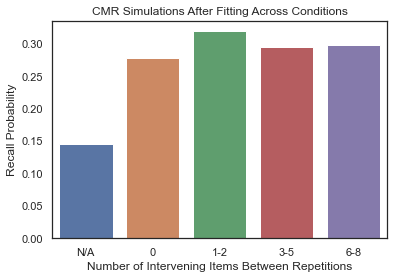

In [10]:
stored_result = [ 0.54926441,  0.12884982,  0.74057096,  0.26469486,  0.18835232,
        0.18321188,  2.88148434, 30.13008952,  0.04958878,  0.21112143,
        5.58388858]

cmr_result = sim_recall_probability_by_lag(
    CMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('CMR Simulations After Fitting Across Conditions')
plt.show()

#### Fitted Across All Conditions

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.84it/s]

[0.30971939 0.485      0.51473214 0.52786905 0.53367857]
[0.17528061 0.02973214 0.0131369  0.00580952]


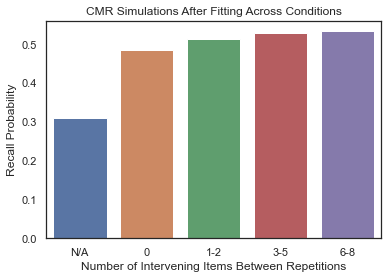

In [61]:
# fit across all conditions
stored_result = [8.44186613e-01, 4.82922372e-01, 9.64152301e-01, 4.66982063e-02,
       2.22044605e-16, 4.11208644e-01, 4.38262927e+00, 3.66252400e-01,
       2.51594034e-02, 1.01416573e-01, 1.14461246e+00]

cmr_result = sim_recall_probability_by_lag(
    CMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('CMR Simulations After Fitting Across Conditions')
plt.show()

#### Just the 4th Condition

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]

[0.31699235 0.52007143 0.5735     0.58645238 0.58685714]
[0.20307908 0.05342857 0.01295238 0.00040476]


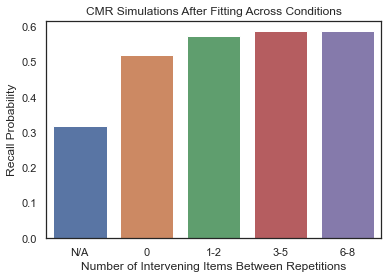

In [62]:
stored_result = [8.46529122e-01, 5.31498507e-01, 9.75056709e-01, 4.26670303e-02,
       2.22044605e-16, 4.83256935e-01, 2.71210420e+00, 4.16117716e+01,
       2.13758709e-02, 1.06864959e-01, 1.23391835e+00]

cmr_result = sim_recall_probability_by_lag(
    CMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('CMR Simulations After Fitting Across Conditions')
plt.show()

### InstanceCMR

#### Echo, Murd62 Dataset Params

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]

[0.14932143 0.314      0.33891071 0.34672619 0.34869048]
[0.16467857 0.02491071 0.00781548 0.00196429]


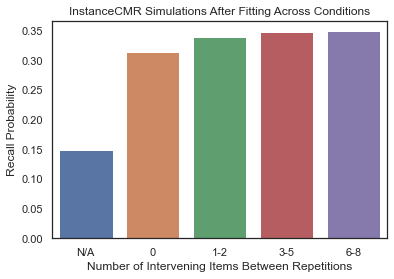

In [63]:
from instance_cmr.models import InstanceCMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

parameters = {
    'presentation_count': list_length,
    'context_sensitivity': 1,
    'feature_sensitivity': 1
}

stored_result = [7.35396287e-01, 1.87003498e-02, 9.02468034e-01, 4.02430122e-03,
       1.00000000e+00, 1.10964824e-01, 1.01153545e+01, 7.00452937e+01,
       3.45770082e-02, 2.57315752e-01, 1.27029929e+00]

cmr_result = sim_recall_probability_by_lag(
    InstanceCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('InstanceCMR Simulations After Fitting Across Conditions')
plt.show()

#### Echo-Based, All Conditions

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s]

[0.29839796 0.49467857 0.54669643 0.56225    0.56704762]
[0.19628061 0.05201786 0.01555357 0.00479762]


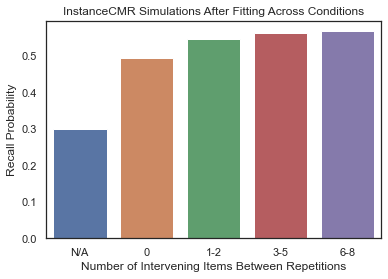

In [64]:
from instance_cmr.models import InstanceCMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

parameters = {
    'presentation_count': list_length,
    'context_sensitivity': 1,
    'feature_sensitivity': 1
}

stored_result = [8.85729103e-01, 8.64309296e-01, 9.72950128e-01, 9.69878669e-05,
       2.12559236e-02, 2.29115877e-02, 2.12408541e+00, 6.16905440e+01,
       2.51658967e-02, 1.01416770e-01, 9.63953204e-01]

cmr_result = sim_recall_probability_by_lag(
    InstanceCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('InstanceCMR Simulations After Fitting Across Conditions')
plt.show()

#### Echo-Based, First Condition

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]

[0.33939796 0.49982143 0.54042857 0.55983333 0.5644881 ]
[0.16042347 0.04060714 0.01940476 0.00465476]


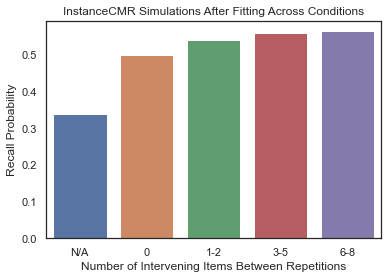

In [65]:
from instance_cmr.models import InstanceCMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

parameters = {
    'presentation_count': list_length,
    'context_sensitivity': 1,
    'feature_sensitivity': 1
}

stored_result = [9.27680726e-01, 2.19052136e-01, 9.96823218e-01, 2.57065752e-04,
       5.44460212e-01, 2.37385091e-01, 2.38541093e+01, 9.60950231e-01,
       2.35458005e-02, 9.14176255e-02, 5.20733974e-01]

cmr_result = sim_recall_probability_by_lag(
    InstanceCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('InstanceCMR Simulations After Fitting Across Conditions')
plt.show()

#### Echo-Based, Conditions 2-4

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.85it/s]

[0.28996344 0.49057143 0.53880357 0.55217857 0.56052381]
[0.20060799 0.04823214 0.013375   0.00834524]


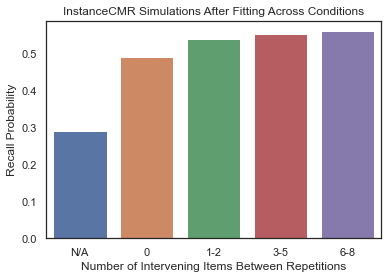

In [66]:
from instance_cmr.models import InstanceCMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

parameters = {
    'presentation_count': list_length,
    'context_sensitivity': 1,
    'feature_sensitivity': 1
}

stored_result = [8.76094526e-01, 8.52373452e-01, 9.70242081e-01, 1.88866325e-04,
       3.98399638e-02, 3.24525612e-02, 2.38791407e+00, 6.66023782e+01,
       2.19539367e-02, 1.20933358e-01, 9.80864346e-01]

cmr_result = sim_recall_probability_by_lag(
    InstanceCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('InstanceCMR Simulations After Fitting Across Conditions')
plt.show()

#### Instance-Based, Murd 62

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.13it/s]

[0.14936139 0.30732143 0.33878571 0.34703571 0.35194048]
[0.15796003 0.03146429 0.00825    0.00490476]


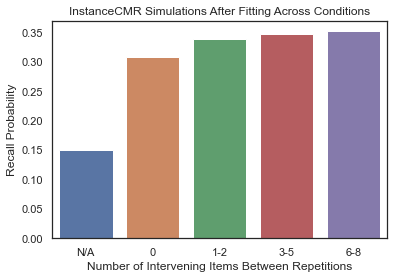

In [67]:
from instance_cmr.models import InstanceCMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'context_sensitivity']

parameters = {
    'presentation_count': list_length,
    'choice_sensitivity': 1,
    'feature_sensitivity': 1
}

stored_result = [7.50643542e-01, 1.42483068e-02, 8.99035619e-01, 9.60870298e-04,
       2.30959697e-01, 9.61676960e-02, 7.80989503e+00, 6.29317080e+01,
       3.44289419e-02, 2.57667853e-01, 1.20133645e+00]

cmr_result = sim_recall_probability_by_lag(
    InstanceCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('InstanceCMR Simulations After Fitting Across Conditions')
plt.show()

#### Instance-Based, First Condition

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]

[0.32584099 0.53278571 0.57319643 0.59202381 0.59728571]
[0.20694473 0.04041071 0.01882738 0.0052619 ]


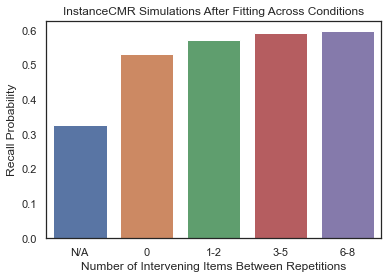

In [68]:
from instance_cmr.models import InstanceCMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'context_sensitivity']

parameters = {
    'presentation_count': list_length,
    'choice_sensitivity': 1,
    'feature_sensitivity': 1
}

stored_result = [9.84725082e-01, 6.18614650e-01, 9.99888330e-01, 2.18012206e-06,
       2.76591916e-01, 7.33807988e-01, 8.24784048e+01, 9.46421512e+01,
       2.35978806e-02, 9.12987996e-02, 3.02041112e-01]

cmr_result = sim_recall_probability_by_lag(
    InstanceCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('InstanceCMR Simulations After Fitting Across Conditions')
plt.show()

#### Instance-Based, Conditions 2-4

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.85it/s]

[0.29235119 0.49328571 0.542      0.55508333 0.56216667]
[0.20093452 0.04871429 0.01308333 0.00708333]


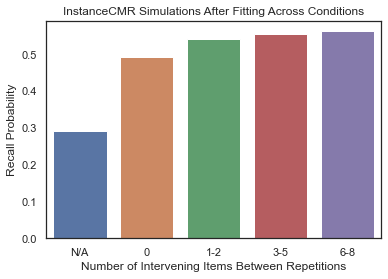

In [69]:
from instance_cmr.models import InstanceCMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'context_sensitivity']

parameters = {
    'presentation_count': list_length,
    'choice_sensitivity': 1,
    'feature_sensitivity': 1
}

stored_result = [8.81678157e-01, 6.77627307e-01, 9.84423376e-01, 1.40316632e-04,
       4.33123134e-02, 1.40160529e-02, 6.40805490e+00, 4.40322799e+01,
       2.19419807e-02, 1.20925596e-01, 8.40359946e-01]

cmr_result = sim_recall_probability_by_lag(
    InstanceCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

print(cmr_result[-1])
print(cmr_result[-1][1:] - cmr_result[-1][:-1])

sns.set_theme(style="white")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('InstanceCMR Simulations After Fitting Across Conditions')
plt.show()